In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from collections import defaultdict,Counter
from tools.MyClock import MyClock
clk = MyClock()

# get label distribution

In [2]:
df = pd.read_pickle('data/sic_hierarchy.pkl')

In [3]:
df.head()

,text,categories,train/test,sic,cat0,cat1,cat2,cat3,hierarchy,sequence
id,,,,,,,,,,
453844,welcome to a1 lifts . professional and reliabl...,"[C, C33, C3319, C33190]",train,C33190,[C],[C33],[C3319],[C33190],[C33190],"[48, 7, 3871, 2402, 63, 2, 436, 2046, 746, 81,..."
914843,"our friendly service , surprising range of fre...","[G, G47, G4711, G47110]",train,G47110,[G],[G47],[G4711],[G47110],[G47110],"[13, 134, 30, 2019, 25, 5, 495, 2, 1707, 36, 2..."
326959,"wherever you want to get to in life , lloyds b...","[K, K64, K6419, K64191]",train,K64191,[K],[K64],[K6419],[K64191],[K64191],"[1075, 16, 243, 7, 72, 7, 4, 220, 1328, 186, 9..."
541943,stanley gibbons – the home of stamp collecting...,"[G, G47, G4778, G47789]",test,G47789,[G],[G47],[G4778],[G47789],[G47789],"[5523, 16256, 271, 3, 32, 5, 7892, 8629, 650, ..."
445157,are you looking for high - quality dentistry i...,"[Q, Q86, Q8623, Q86230]",train,Q86230,[Q],[Q86],[Q8623],[Q86230],[Q86230],"[17, 16, 154, 8, 70, 31, 1004, 4, 490, 54, 3, ..."


In [4]:
df = df[df['train/test']=='train']

In [5]:
cols = sorted([d for d in df.columns if d.startswith('cat') and not d=='categories'])
cats=[]
for col in cols:
    classes = df[col].apply(lambda x:x[0])
    cats.append(classes.value_counts().to_dict())

In [6]:
hs = df.categories.apply(lambda x:' -> '.join(x))


In [7]:
groups = [set()for i in range(4)]
i = 0
quant = len(df)/4
num = 0
cut = []
for key,val in hs.value_counts(ascending=True).iteritems():
    num+=val
    if num>(i+1)*quant:
        cut.append(val)
        i+=1
    groups[i].add(key)

In [8]:
# check that each group has roughly the same number of training samples
vc = hs.value_counts().to_dict()
cnts = []
for group in groups:
    i = 0
    for key in list(group):
        i+=vc[key]
    cnts.append(i)
cnts

[142689, 142432, 137341, 149639]

In [9]:
group_cnts = [[[]for _ in range(len(cols))] for _ in range(len(groups))]
for i,group in enumerate(groups):
    for j,cc in enumerate(zip(*[a.split(' -> ') for a in list(group)])):
        for c in list(set(cc)):
            group_cnts[i][j].append(cats[j][c])

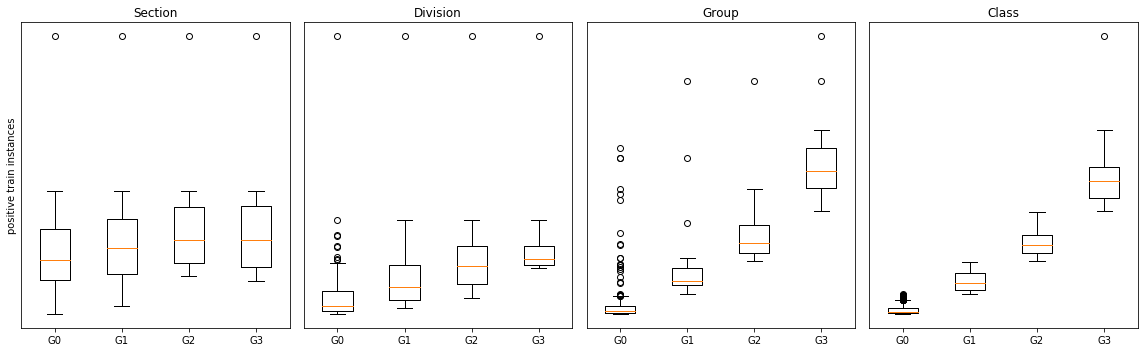

In [10]:
# labels = []
# labels.append('cnt<{}'.format(cut[0]))
# labels.append('{}<cnt<{}'.format(cut[0],cut[1]))
# labels.append('{}<cnt<{}'.format(cut[1],cut[2]))
# labels.append('{}<cnt'.format(cut[2]))
titles = ['Section','Division','Group','Class']
labels = ['G{}'.format(i) for i in range(4)]
fig,axes = plt.subplots(1,len(cols),figsize=(4*len(cols),5))
for i in range(len(cols)):
    axes[i].boxplot([group_cnts[c][i] for c in range(4) ],labels=labels)
    axes[i].set_yticks([])
    axes[i].set_title(titles[i])
axes[0].set_ylabel('positive train instances')
plt.tight_layout()
plt.show()

## get data imbalence relationship with depth

In [11]:
from tools.model_func import get_input

W0825 18:29:30.101193 140609353299776 deprecation_wrapper.py:119] From /home/angela/xmtc/tools/model_func.py:21: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



In [33]:
_,y_trains,_,_ = get_input('data/amazon_hierarchy_2','cat',True,[0,1,0,0])

In [34]:
cnts = [y.sum(axis=0).A1 for y in y_trains]

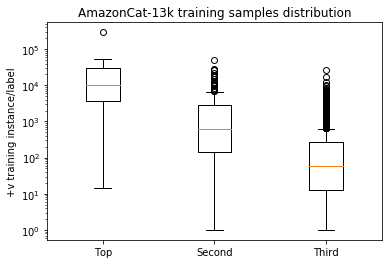

In [36]:
# labels = ['Section','Division','Group','Class']
labels = ['Top','Second','Third']
plt.boxplot(cnts,labels=labels)
plt.title('AmazonCat-13k training samples distribution')
plt.yscale('log')
plt.ylabel('+v training instance/label')
plt.show()

# amazon data examples

In [ ]:
df = pd.read_pickle('data/amazon_des.pkl')

In [ ]:
# read categories (hierarchy)
CAT_DIR = './Amazon_RawData/categories.txt'
CAT_MAP_DIR = "./AmazonCat-13K_mappings/AmazonCat-13K_label_map.txt"
with open(CAT_MAP_DIR,'r',encoding = "ISO-8859-1") as f:
    cats_map = f.read().splitlines()
cats_set = set([c.lower() for c in cats_map])
with open(CAT_DIR,'r',encoding = "ISO-8859-1") as f:
    lines = f.read().splitlines()
data = defaultdict(list)
invalid = []
for i,line in enumerate(lines):
    if line[0]!=' ':
        id = line
    elif line[:2]=='  ':
        cats = [t.strip().lower() for t in line.split(',')]
        cats = [c for c in cats if c in cats_set]
        if cats:
            data[id].append(cats)
        else:
            invalid.append((i,line))
    else:
        raise Exception('invalide line {} : {}'.format(i,line))
print(set([line for i,line in invalid]))

In [ ]:
data = {key:data[key] for key in df.index.values}

In [ ]:
woop = {}
for key,val in data.items():
    if len(val)>1:
        woop[key] = [' $>$ '.join(v) for v in val]

In [ ]:
woop

# get data dimensions

In [2]:
from tools.model_func import get_input

W0821 18:20:36.478215 140184857188160 deprecation_wrapper.py:119] From /home/angela/xmtc/tools/model_func.py:21: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



In [3]:
IN_DIR = 'data/amazon_hierarchy'

In [4]:
tok = pickle.load(open(os.path.join(IN_DIR,'tokenizer.pkl'),'rb'))

In [5]:
tok.num_words

50000

In [6]:
_,ytr,_,yte = get_input(in_dir=IN_DIR,mode = 'cat',get_output=[0,1,0,1])

In [7]:
[y.shape[1] for y in ytr],sum([y.shape[1] for y in ytr])

([29, 293, 2227], 2549)

In [8]:
ytr[0].shape,yte[0].shape

((744195, 29), (195251, 29))

# max pooling

In [33]:
aa = np.random.randint(0,10,size=(4,4))

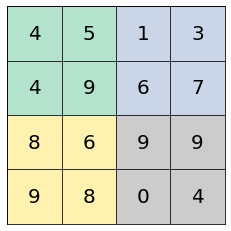

In [43]:
bb = np.array([[0,0,1,1],[0,0,1,1],[2,2,3,3],[2,2,3,3]])
fig,ax = plt.subplots()
for (i, j), z in np.ndenumerate(aa):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center',fontsize=20)
ax.matshow(bb,cmap=plt.get_cmap('Pastel2'))
ax.set_xticks(np.arange(-.5, 4, 1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(-.5, 4, 1))
ax.set_yticklabels([])
ax.grid('on',color='k')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

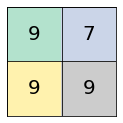

In [44]:
cc = np.array([[9,7],[9,9]])
dd = np.array([[0,1],[2,3]])
fig,ax = plt.subplots(figsize=(2,2))
for (i, j), z in np.ndenumerate(cc):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center',fontsize=20)
ax.matshow(dd,cmap=plt.get_cmap('Pastel2'))
ax.set_xticks(np.arange(-.5, 2, 1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(-.5, 2, 1))
ax.set_yticklabels([])
ax.grid('on',color='k')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

# data distribution

In [91]:
from tools.model_func import get_input
_,y_trains,_,_ = get_input('data/sic_hierarchy','cat',False,[0,1,0,0])

In [92]:
yy = [y.argmax(axis=1) for y in y_trains]
cnts = []
for y in yy:
    _,c = np.unique(y,return_counts=True)
    cnts.append(c)
cnts = np.concatenate(cnts)

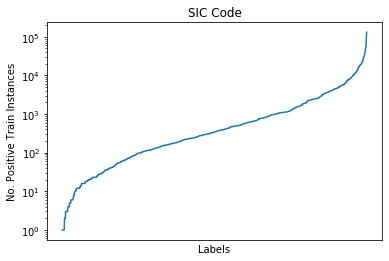

In [93]:
plt.plot(sorted(cnts))
plt.yscale('log')
plt.xticks([])
plt.xlabel('Labels')
plt.ylabel('No. Positive Train Instances')
plt.title('SIC Code')
plt.show()

In [85]:
cnts = [y.shape[1] for y in y_trains]
offset = [sum(cnts[:i]) for i in range(len(cnts))]

In [86]:
offset

[0, 18, 95, 548]

In [87]:
yy  = np.concatenate([offset[i]+y for i,y in enumerate(yy)])

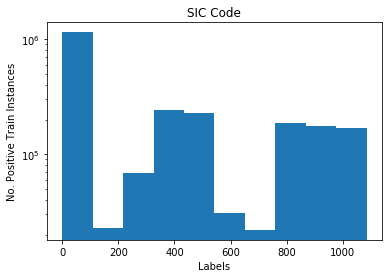

In [89]:
plt.hist(yy)
plt.yscale('log')
# plt.xticks([])
plt.xlabel('Labels')
plt.ylabel('No. Positive Train Instances')
plt.title('SIC Code')
plt.show()